In [ ]:
pip install sklearn matplotlib

In [ ]:
pip install transformers

In [ ]:
pip install nltk

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.notebook import tqdm
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("bucketresearch/politicalBiasBERT")

Token indices sequence length is longer than the specified maximum sequence length for this model (4690 > 512). Running this sequence through the model will result in indexing errors


             id  Token Length
0       3933475          4690
1      39110219          2316
2       3903026          1411
3       3940989           700
4       4334705           323
...         ...           ...
3039  115856590          1081
3040  115960558          1082
3041    4337424           416
3042    4309962           619
3043  131719699           755

[3044 rows x 2 columns]

Statistical Measures:
Mean Token Length: 900.9392247043364
Median Token Length: 790.5
Maximum Token Length: 21389
Minimum Token Length: 28


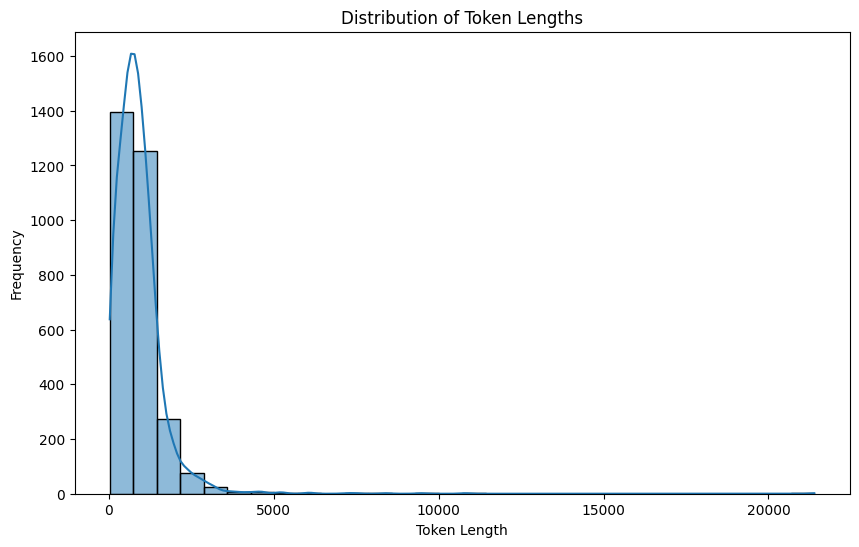

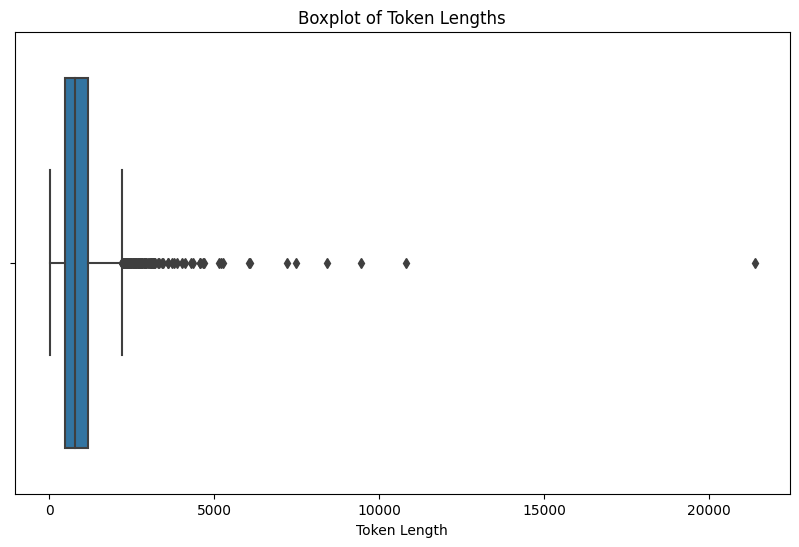

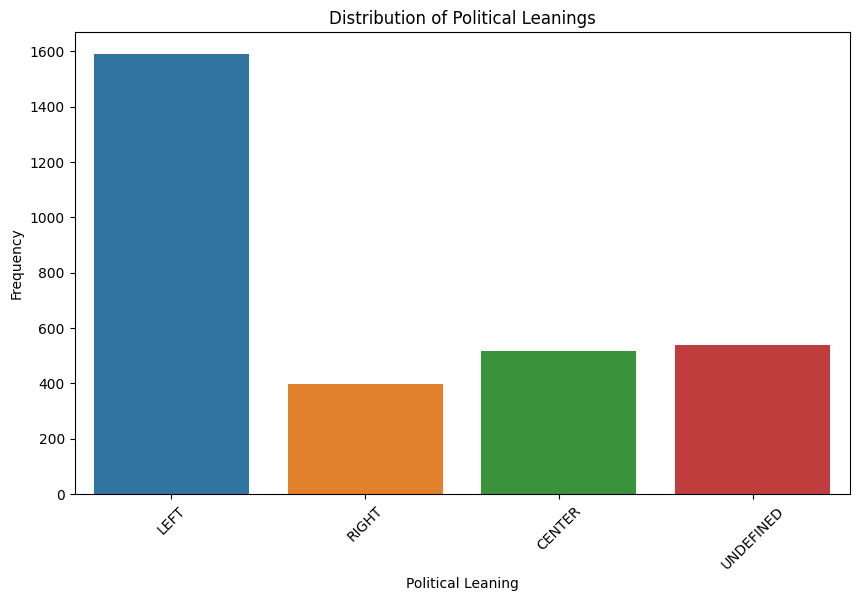

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Path to the CSV file
csv_file_path = '/content/climate_change_headlines.csv'

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Calculate token lengths for each article
df['Token Length'] = df.apply(lambda row: len(tokenizer.encode(row['headline'] + " " + row['body'], add_special_tokens=True)), axis=1)

# Display the DataFrame with Token Lengths
print(df[['id', 'Token Length']])

# Statistical measures
print("\nStatistical Measures:")
print(f"Mean Token Length: {df['Token Length'].mean()}")
print(f"Median Token Length: {df['Token Length'].median()}")
print(f"Maximum Token Length: {df['Token Length'].max()}")
print(f"Minimum Token Length: {df['Token Length'].min()}")

# Plotting Token Length Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Token Length'], bins=30, kde=True)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

# Boxplot for Token Lengths
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Token Length'])
plt.title('Boxplot of Token Lengths')
plt.xlabel('Token Length')
plt.show()

# Plotting Political Leaning Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='political_leaning')
plt.title('Distribution of Political Leanings')
plt.xlabel('Political Leaning')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


100%|██████████| 2506/2506 [1:25:47<00:00,  2.05s/it]

Accuracy: 0.5750
              precision    recall  f1-score   support

      center       0.32      0.44      0.37       517
        left       0.76      0.66      0.71      1590
       right       0.40      0.41      0.41       399

    accuracy                           0.58      2506
   macro avg       0.49      0.51      0.49      2506
weighted avg       0.61      0.58      0.59      2506



<Figure size 1000x700 with 0 Axes>

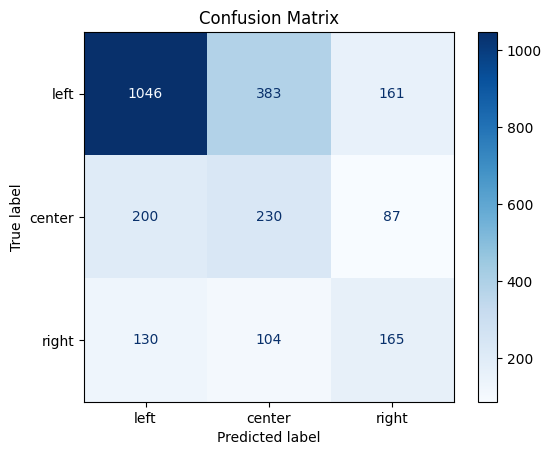

In [ ]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("bucketresearch/politicalBiasBERT")
stance_mapping = {0: 'left', 1: 'center', 2: 'right'}


# Function to chunk text by sentences
def chunk_text_by_sentences(text, max_tokens):
    sentences = sent_tokenize(text)
    token_chunks = []
    current_chunk = []

    for sentence in sentences:
        sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)
        if len(current_chunk) + len(sentence_tokens) > max_tokens:
            token_chunks.append(current_chunk)
            current_chunk = sentence_tokens
        else:
            current_chunk.extend(sentence_tokens)

    if current_chunk:
        token_chunks.append(current_chunk)

    return token_chunks

def get_model_prediction(text_chunks):
    probs_list = []

    for chunk in text_chunks:
        # Convert token ids to text
        chunk_text = tokenizer.decode(chunk)

        # Tokenize the text
        inputs = tokenizer(chunk_text, return_tensors='pt', padding='max_length', truncation=True, max_length=512)


        # Pass the inputs to the model
        outputs = model(**inputs)
        logits = outputs.logits
        probs = logits.softmax(dim=-1).squeeze().tolist()
        probs_list.append(probs)

        # Calculate the median probabilities
        probs_array = np.array(probs_list)
        median_probs = np.median(probs_array, axis=0)
        predicted_stance = stance_mapping[np.argmax(median_probs)]

        return predicted_stance

# Read the CSV file and preprocess data
csv_file_path = '/content/climate_change_headlines.csv'
df = pd.read_csv(csv_file_path)
df = df[df['political_leaning'] != 'UNDEFINED']

true_labels = []
predicted_labels = []

# Loop through the DataFrame
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    # Convert each column to string, handling NaN values
    headline = str(row['headline']) if not pd.isna(row['headline']) else ''
    body = str(row['body']) if not pd.isna(row['body']) else ''

    full_text = headline + " " + body
    true_labels.append(row['political_leaning'].lower())

    # Chunk text
    text_chunks = chunk_text_by_sentences(full_text, max_tokens=512)
    predicted_labels.append(get_model_prediction(text_chunks))

# Evaluate and plot
evaluation_df = pd.DataFrame({'True_Labels': true_labels, 'Predicted_Labels': predicted_labels})
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(true_labels, predicted_labels))

ordered_labels = ['left', 'center', 'right']
matrix = confusion_matrix(evaluation_df['True_Labels'], evaluation_df['Predicted_Labels'], labels=ordered_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=ordered_labels)
plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


100%|██████████| 2506/2506 [2:36:09<00:00,  3.74s/it]


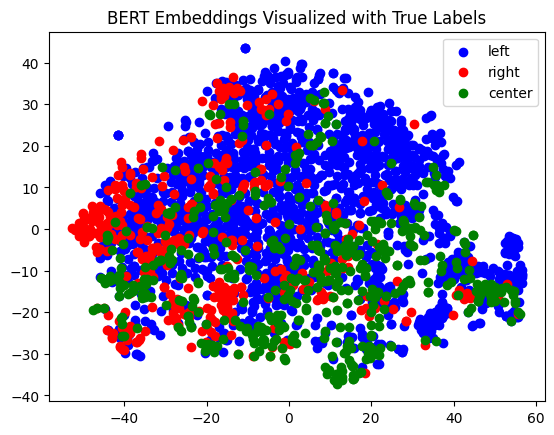

In [ ]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("bucketresearch/politicalBiasBERT")

# Modified get_bert_embeddings function
def get_bert_embeddings(text_chunks):
    all_embeddings = []

    for chunk in text_chunks:
        # Convert token ids to text
        chunk_text = tokenizer.decode(chunk)

        tokenized_inputs = tokenizer(chunk_text, truncation=True, return_tensors='pt', max_length=512)
        inputs = {'input_ids': tokenized_inputs['input_ids'], 'attention_mask': tokenized_inputs['attention_mask']}
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
        embeddings = outputs.hidden_states[-2][0].mean(dim=0)
        all_embeddings.append(embeddings.numpy())

   # Aggregate embeddings using median
    aggregated_embeddings = np.median(all_embeddings, axis=0)
    return aggregated_embeddings

embeddings = []
true_labels = []


# Read the CSV file and preprocess data
csv_file_path = '/content/climate_change_headlines.csv'
df = pd.read_csv(csv_file_path)
df = df[df['political_leaning'] != 'UNDEFINED']

true_labels = []
predicted_labels = []

# Loop through the DataFrame instead of files
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    # Convert each column to string, handling NaN values
    headline = str(row['headline']) if not pd.isna(row['headline']) else ''
    body = str(row['body']) if not pd.isna(row['body']) else ''

    full_text = headline + " " + body
    text_chunks = chunk_text_by_sentences(full_text, max_tokens=512)

    emb = get_bert_embeddings(text_chunks)
    embeddings.append(emb)
    true_labels.append(row['political_leaning'].lower())

# Convert to NumPy array and perform dimensionality reduction
embeddings_array = np.array(embeddings)
embeddings_reduced = TSNE(n_components=2, random_state=42).fit_transform(embeddings_array)

# Plotting
unique_labels = set(true_labels)
for label in unique_labels:
    indices = [i for i, x in enumerate(true_labels) if x == label]
    color = 'red' if label == 'right' else 'blue' if label == 'left' else 'green'
    plt.scatter(embeddings_reduced[indices, 0], embeddings_reduced[indices, 1], c=color, label=label)
plt.legend()
plt.title("BERT Embeddings Visualized with True Labels")
plt.show()


In [ ]:
import plotly.graph_objs as go


tsne_3d = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne_3d.fit_transform(embeddings_array)

# Create a trace for each different label
traces = []
colors = {'left': 'blue', 'center': 'green', 'right': 'red'}
for label in set(true_labels):
    indices = [i for i, l in enumerate(true_labels) if l == label]
    trace = go.Scatter3d(
        x=embeddings_3d[indices, 0],
        y=embeddings_3d[indices, 1],
        z=embeddings_3d[indices, 2],
        mode='markers',
        marker=dict(
            size=5,
            opacity=0.8,
            line=dict(width=0.5, color='white'),
            color=colors[label]
        ),
        name=label
    )
    traces.append(trace)

# Define the layout of the plot
layout = go.Layout(
    title="BERT Embeddings Visualized in 3D with True Labels",
    margin=dict(l=0, r=0, b=0, t=30),
    legend=dict(x=0.1, y=1, xanchor="left", yanchor="top"),
    # scene=dict(
    #     xaxis=dict(title='Component 1'),
    #     yaxis=dict(title='Component 2'),
    #     zaxis=dict(title='Component 3'),
    # )
)

# Create the figure and plot it
fig = go.Figure(data=traces, layout=layout)
fig.show()

In [ ]:
from google.colab import files

In [ ]:
fig.write_html('Emb_Plot.html')

In [ ]:
# Save as a binary file
np.save('embeddings_array.npy', embeddings_array)

# Convert to DataFrame and save as CSV for a human-readable format
embeddings_df = pd.DataFrame(embeddings_array)
embeddings_df.to_csv('embeddings_array.csv', index=False)

In [ ]:
files.download('Emb_Plot.html')
files.download('embeddings_array.npy')
files.download('embeddings_array.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('embeddings_array.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

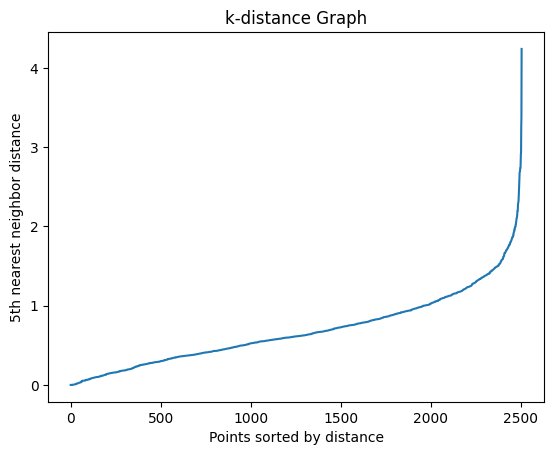

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np


neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(embeddings_reduced)
distances, indices = neighbors_fit.kneighbors(embeddings_reduced)

# Sort the distances
distances = np.sort(distances, axis=0)
distances = distances[:, 1]  # Second nearest point

plt.plot(distances)
plt.title('k-distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('5th nearest neighbor distance')
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


# Apply DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=5).fit(embeddings_reduced)

# Get the cluster labels (note: -1 means outlier)
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# Create a 2D scatter plot
plt.figure(figsize=(12, 8))

# Color map
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = embeddings_reduced[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], label=f'Cluster {k}' if k != -1 else 'Noise')

plt.title('DBSCAN clustering')
plt.legend()
plt.show()


In [ ]:
pip install umap-learn


In [ ]:
import umap
import time

# Sample a smaller subset of your data for timing
small_sample = embeddings

start_time = time.time()
reducer = umap.UMAP(random_state=42)
embs = reducer.fit_transform(small_sample)
end_time = time.time()

print(f"Time taken for 100 samples: {end_time - start_time} seconds")

# Now you can estimate the time for the full dataset
estimated_full_time = (end_time - start_time) * (len(embeddings) / 100)
print(f"Estimated time for full dataset: {estimated_full_time / 60} minutes")


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



Time taken for 100 samples: 19.01163387298584 seconds
Estimated time for full dataset: 7.940525747617086 minutes


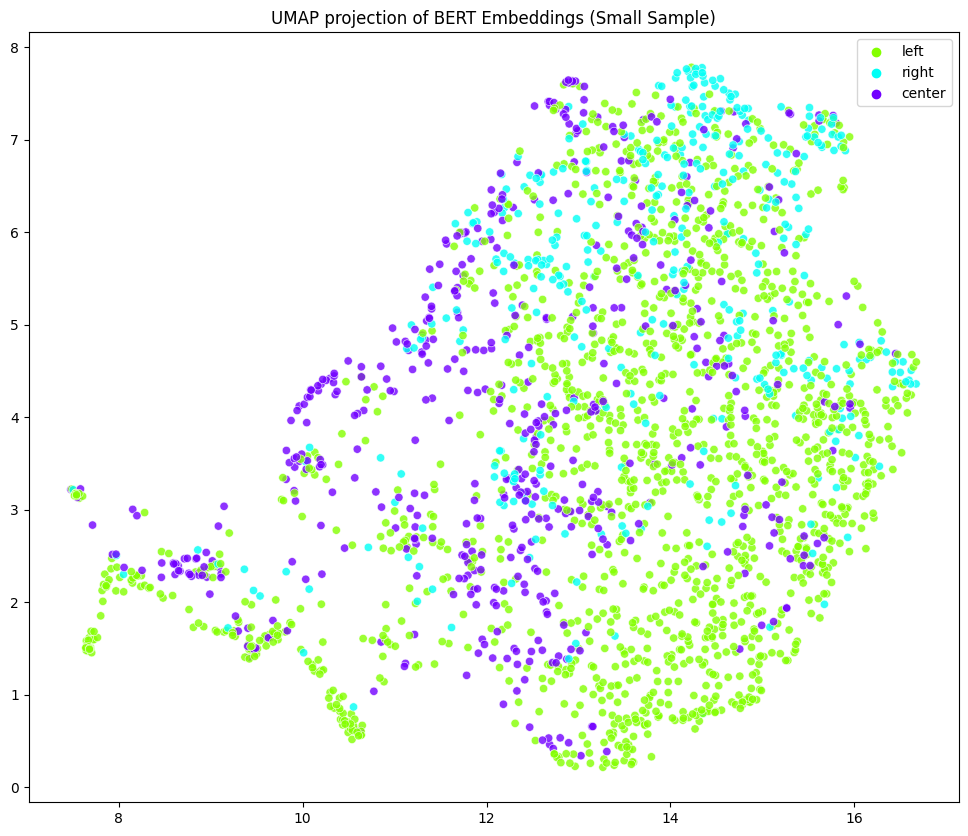

In [ ]:

small_true_labels = true_labels  # Adjust to match the number of samples in 'small_sample'

# Now plotting the UMAP embeddings with the corresponding labels
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x=embs[:, 0], y=embs[:, 1],
    hue=small_true_labels,  # Make sure this matches the number of points in 'embs'
    palette=sns.color_palette("hsv", len(set(small_true_labels))),
    legend="full",
    alpha=0.8
)
plt.title('UMAP projection of BERT Embeddings (Small Sample)')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



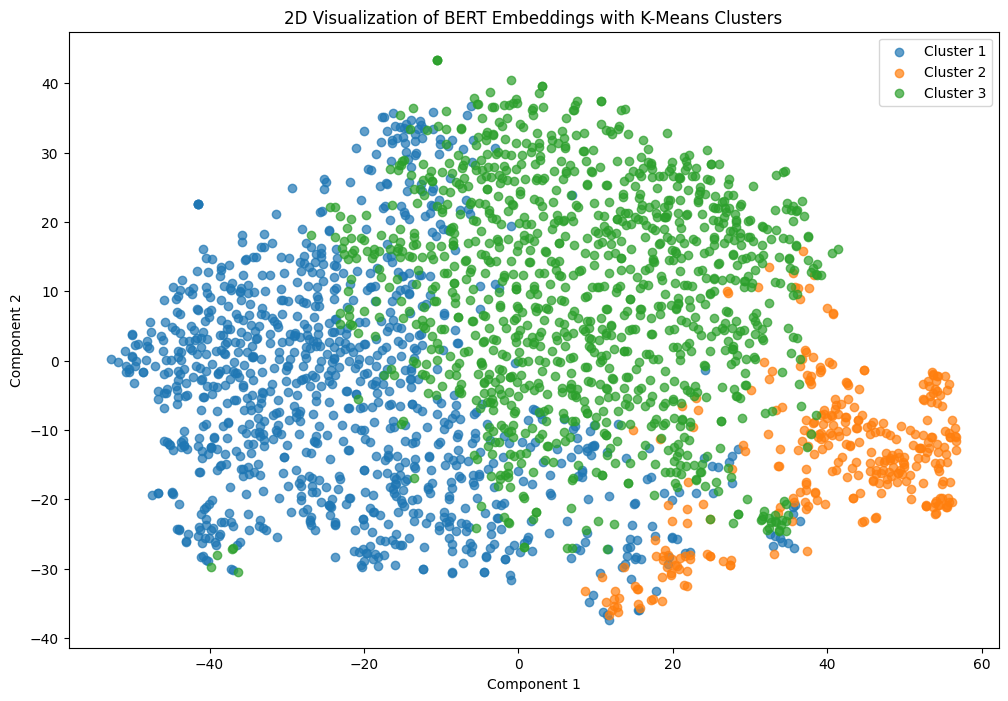

In [ ]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D


# Choose the number of clusters
num_clusters = 3

# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings_array)
cluster_labels = kmeans.labels_

# Plotting
plt.figure(figsize=(12, 8))
for i in range(num_clusters):
    # Extract the 2D embeddings and the corresponding cluster
    indices = [j for j in range(len(cluster_labels)) if cluster_labels[j] == i]
    cluster_embeddings = embeddings_reduced[indices]

    # Scatter plot for each cluster
    plt.scatter(cluster_embeddings[:, 0], cluster_embeddings[:, 1], label=f'Cluster {i+1}', alpha=0.7)

plt.title('2D Visualization of BERT Embeddings with K-Means Clusters')
plt.legend()
plt.show()
plt.show()
